In [2]:
import image_classifier # deserialize_ssd
import numpy as np
import mvnc.mvncapi as mvnc
import os
import PIL.Image
from pathlib import Path

In [3]:
def init_ncs(graph_filename='../Models/MobileNet_SSD_caffe/graph'):
    devices = mvnc.enumerate_devices()
    if len(devices) == 0:
        print('No NCS devices found')
        exit()

    # Get a handle to the first enumerated device and open it
    device = mvnc.Device(devices[0])
    device.open()

    # Read the graph file into a buffer
    with open(graph_filename, mode='rb') as f:
        blob = f.read()

    # Load the graph buffer into the NCS
    graph = mvnc.Graph(graph_filename)
    fifo_in, fifo_out = graph.allocate_with_fifos(device, blob)

    return device, graph, fifo_in, fifo_out

In [4]:
device, graph, fifo_in, fifo_out = init_ncs()

In [5]:
def infer_img(img,
              graph, fifo_in, fifo_out,
              nn_shape=(300,300),
              mean=(127.5, 127.5, 127.5),
              scale=0.00789,
              confidance_threshold=0.7):
    preprocessed_img = (img - np.float32(mean)) * np.float32(scale)

    graph.queue_inference_with_fifo_elem(fifo_in, fifo_out, preprocessed_img, None)
    
    output, userobj = fifo_out.read_elem()

    # Deserialize the output into a python dictionary
    output_dict = image_classifier.deserialize_ssd(output, nn_shape, confidance_threshold)
    
    return output_dict

In [6]:
label_filename='../Models/MobileNet_SSD_caffe/categories.txt'
labels = [line.rstrip('\n') for line in open(label_filename) if line != 'classes\n']
img_dir = 'my_dogs/'

class_of_interest = 'all'
#class_of_interest = labels.index('dog')

In [17]:
imgs = []

for file in os.listdir(img_dir):
    im = PIL.Image.open(img_dir + file).resize((300,300))
    output_dict = infer_img(np.array(im), graph, fifo_in, fifo_out, confidance_threshold=0.2)
    img = display_image(output_dict, class_of_interest, np.array(im), labels)
    
    imgs.append(PIL.Image.fromarray(img))

/usr/local/lib/python3.5/dist-packages/mvnc/mvncapi.py:418: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  tensor = numpy.fromstring(tensor.raw, dtype=numpy.float32)


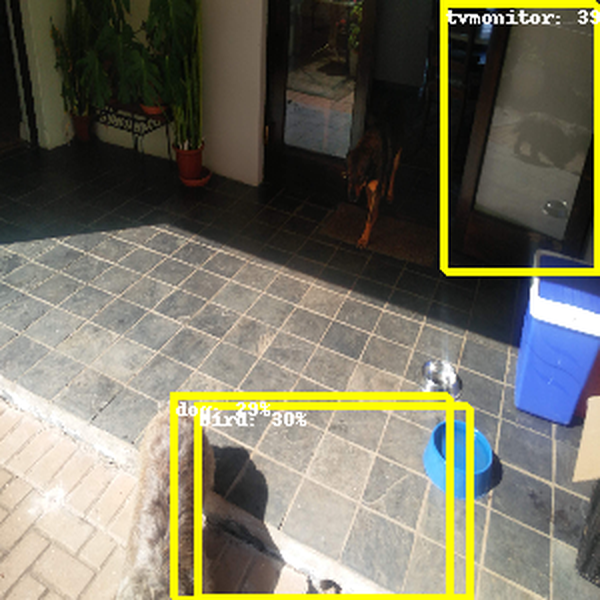

In [18]:
imgs[0].resize((600,600), PIL.Image.ANTIALIAS)

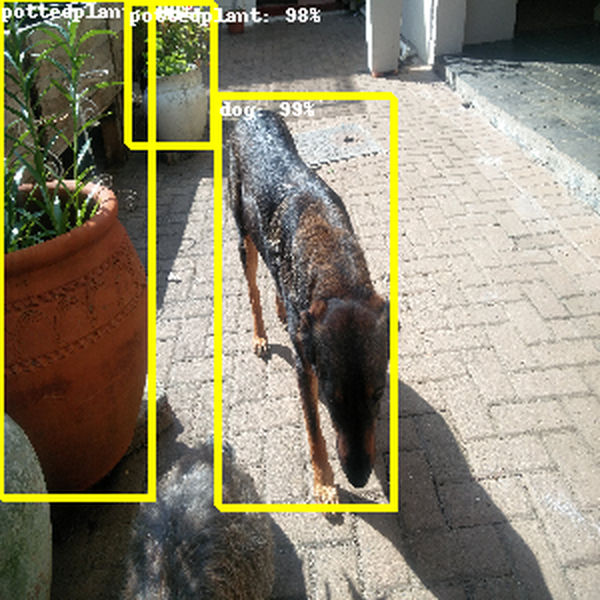

In [19]:
imgs[1].resize((600,600), PIL.Image.ANTIALIAS)

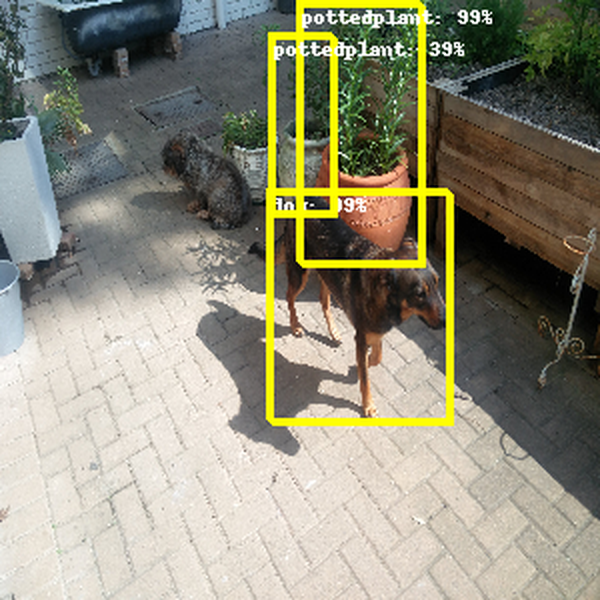

In [20]:
imgs[2].resize((600,600), PIL.Image.ANTIALIAS)

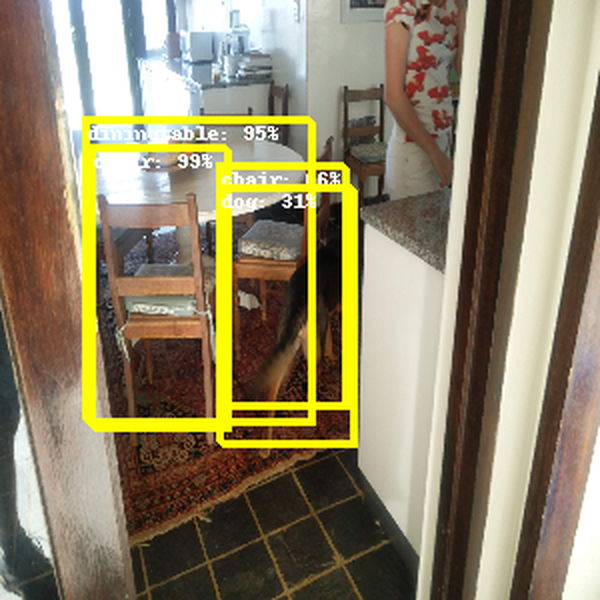

In [21]:
imgs[3].resize((600,600), PIL.Image.ANTIALIAS)

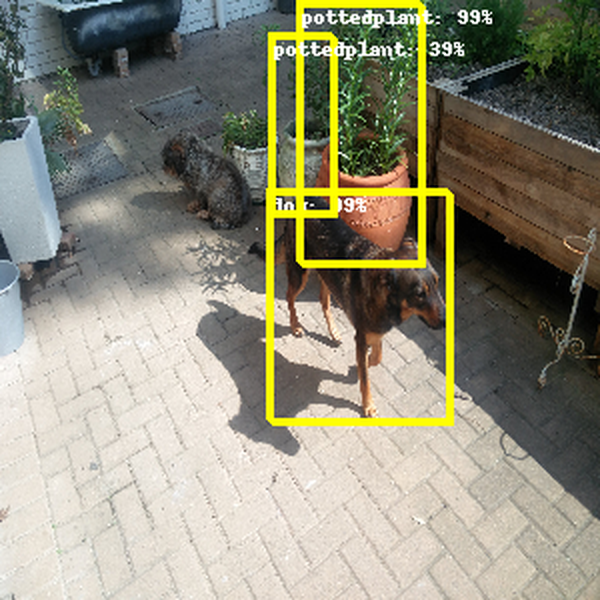

In [22]:
imgs[4].resize((600,600), PIL.Image.ANTIALIAS)

In [8]:
import PIL.Image, PIL.ImageDraw, PIL.ImageFont

def display_image(output_dict, class_of_interest, frame, labels, capture_screenshots=False):
    # Print the results (each image/frame may have multiple objects)
    for i in range(output_dict['num_detections']):
        
        if class_of_interest =='all' or (output_dict.get('detection_classes_' + str(i)) == class_of_interest):
            
            # Extract top-left & bottom-right coordinates of detected objects
            (y1, x1) = output_dict.get('detection_boxes_' + str(i))[0]
            (y2, x2) = output_dict.get('detection_boxes_' + str(i))[1]

            # Prep string to overlay on the image
            display_str = (labels[output_dict.get('detection_classes_%i' % i)]
                           + ': %s%%' % output_dict.get('detection_scores_%i' % i))

            # Overlay bounding boxes, detection class and scores
            frame = draw_bounding_box( 
                        y1, x1, y2, x2,
                        frame, display_str=display_str)

    if capture_screenshots:
        img = PIL.Image.fromarray(frame)
        img.save('captures/photo_%s.jpg' % cur_time)

    # If a display is available, show image on which inference was performed
    if 'DISPLAY' in os.environ:
        img.show()
    
    return frame

# ****************************************************************************
# Copyright(c) 2017 Intel Corporation. 
# License: MIT See LICENSE file in root directory.
# ****************************************************************************

# Utilities to help visualize the output from
# Intel® Movidius™ Neural Compute Stick (NCS)
def draw_bounding_box(y1, x1, y2, x2, 
                      img, 
                      thickness=4, 
                      color=(255, 255, 0),
                      display_str=()):
    """ draw a bounding box on an image to help visualise the nn output
    
    Inputs
        (x1, y1)  = Top left corner of the bounding box
        (x2, y2)  = Bottom right corner of the bounding box
        img       = Image/frame represented as numpy array
        thickness = Thickness of the bounding box's outline
        color     = Color of the bounding box's outline
    """
    img = PIL.Image.fromarray(img)
    draw = PIL.ImageDraw.Draw(img)

    for x in range(0, thickness):
        draw.rectangle([(x1-x, y1-x), (x2-x, y2-x)], outline=color)

    font = PIL.ImageFont.load_default()
    draw.text((x1, y1), display_str, font=font)

    return np.array(img)